In [1]:
# Run preprocessing script to make dataframe objects available.

%run PreProcessing.ipynb

Current Progress: 100.0 %


In [2]:
# Import required libraries.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from dtreeviz.trees import dtreeviz
from mlxtend.evaluate import bias_variance_decomp
from sklearn.pipeline import Pipeline

In [3]:
X = summary_data_avg[['pp2m2', 'heat_units', 'solar_radiation', 'organic_matter', 'method', 'variety', 'inputs', 'protection']]
y = summary_data_avg['mean_diameter']

X.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
0,38,1128,1063757,24.6,Drilled,Krypton,Conventional,Barley
1,41,1394,1236720,24.6,Drilled,Krypton,Conventional,Barley
2,44,1630,1348259,24.6,Drilled,Krypton,Conventional,Barley
3,45,1967,1506984,24.6,Drilled,Krypton,Conventional,Barley
4,40,2256,1619377,24.6,Drilled,Krypton,Conventional,Barley


In [4]:
# Encode categoriccal variables that will be used as predictors
# Error message appearing but code seems to work.

trns = CustomTransformer().fit(X)
X = trns.transform(X)

X.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
0,38,1128,1063757,24.6,2.0,11.0,1.0,0.0
1,41,1394,1236720,24.6,2.0,11.0,1.0,0.0
2,44,1630,1348259,24.6,2.0,11.0,1.0,0.0
3,45,1967,1506984,24.6,2.0,11.0,1.0,0.0
4,40,2256,1619377,24.6,2.0,11.0,1.0,0.0


In [5]:
# Assign 'X' and 'y' values and split into seperate train and test df.
# If there is little benefit from specific indicators they can be removed.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
X_train.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
1654,33,588,746284,24.1,1.0,16.0,1.0,1.0
2377,33,1779,970116,2.1,0.0,20.0,1.0,2.0
1014,36,2215,1292917,36.2,2.0,4.0,1.0,0.0
2327,35,1791,990708,2.6,0.0,9.0,1.0,2.0
2284,31,2603,1844549,1.7,2.0,11.0,1.0,0.0


In [6]:
X_test.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
443,38,2010,1615173,78.7,2.0,5.0,1.0,2.0
1451,62,1994,1349588,13.0,2.0,3.0,0.0,0.0
1977,32,1034,807773,31.9,1.0,22.0,1.0,2.0
1160,70,1600,1377747,18.5,2.0,21.0,0.0,3.0
3217,39,1386,937618,2.5,3.0,4.0,2.0,2.0


In [7]:
# Use the isolation forest algorithm to remove the most rogue 5% of datapoints.

print(f"The old training dataframe shape: {X_train.shape}")

clf1 = IsolationForest(max_samples=500, random_state = 10, contamination = 0.05)
preds = clf1.fit_predict(X_train)

totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

# Remove outliers from training data.
# Do not remove from test data as this is bad practice.
# Confirm removal by checking new df shape.

filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The old training dataframe shape: (2911, 8)
Total number of outliers identified is:  146
The new training dataframe shape: (2765, 8)


In [8]:
# Hypertuning model to find best parameters.
# Print the best qualitative parameters to use within the model.

param_grid = {'random_state': [1],
              'max_features': ['sqrt', 'auto', 'log2'],
              'bootstrap': [True, False]}  
   
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs= 2)

grid_rfr.fit(X_train, y_train) 
 
print(grid_rfr.best_params_)   

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'bootstrap': True, 'max_features': 'auto', 'random_state': 1}


In [9]:
# Fit semi-hypertuned model and print score.

rfr = Pipeline([('rfr', RandomForestRegressor(bootstrap = True, max_features = 'auto', random_state = 1))])

rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9348309053977941


In [10]:
def hypertune_eval(param, seq_min, seq_max, seq_int, model):
    
    sequence = np.arange(seq_min, seq_max, seq_int)
    acc = []
    bias = []
    var = []
    mse = []
    
    for n in sequence:
        model[-1].set_params(**{param : n})
        model.fit(X_train, y_train)
        acc.append(model.score(X_test, y_test))

        mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(model, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 10, random_seed = 1)
        
        bias.append(bias_decomp)
        var.append(var_decomp)
        mse.append(mse_decomp)
        
        
    fig, axs = plt.subplots(2, 2, figsize=(8, 5), constrained_layout=True, sharex=True)
    
    fig.suptitle(f'Effect of Changing {param} Parameter')
    fig.supxlabel(f'{param}')
    
    axs[0,0].plot(sequence, acc)
    axs[0,0].set_ylabel('accuracy')
    
    axs[0,1].plot(sequence, mse)
    axs[0,1].set_ylabel('mean squared error')
    
    axs[1,0].plot(sequence, bias)
    axs[1,0].set_ylabel('bias')
    
    axs[1,1].plot(sequence, var)
    axs[1,1].set_ylabel('variance')
        

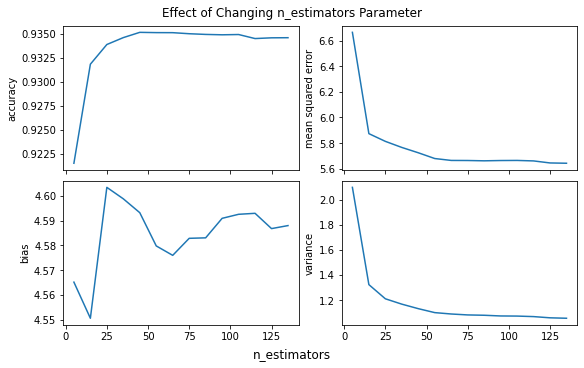

In [11]:
# Optimisation of n_estimators parameter.

hypertune_eval('n_estimators', 5, 145, 10, rfr)

In [12]:
# Set parameter to optimum.

rfr[-1].set_params(n_estimators = 75)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9348309053977941


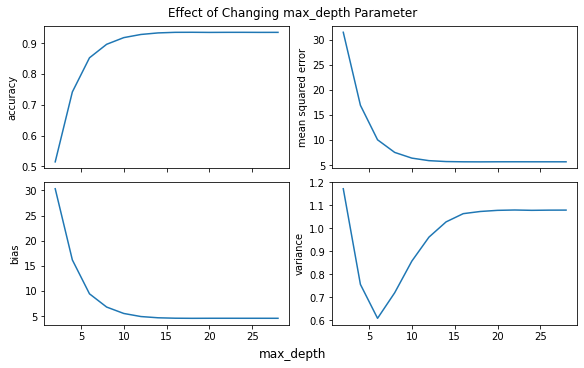

In [13]:
# Optimisation for max_depth parameter.

hypertune_eval('max_depth', 2, 20, 2, rfr)

In [14]:
# Set parameter to optimum and retest score.

rfr[-1].set_params(max_depth = 12)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9347400528179267


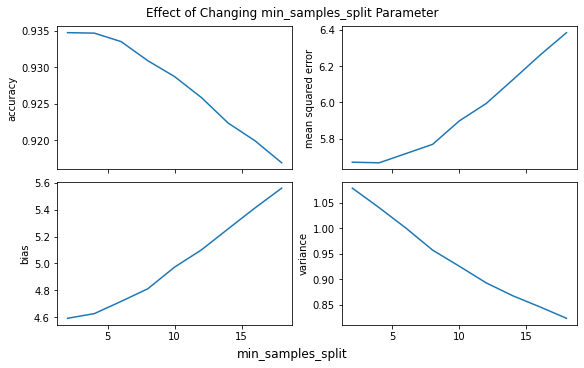

In [15]:
# Optimisation for min_samples_split parameter.

hypertune_eval('min_samples_split', 2, 20, 2, rfr)

In [16]:
# Set parameter to optimum and retest score.

rfr[-1].set_params(min_samples_split = 5)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.933556292652533


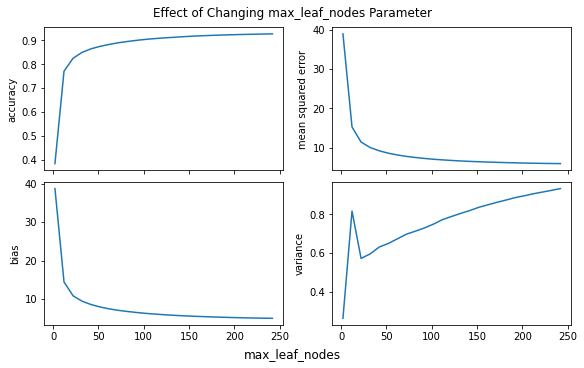

In [17]:
# Optimisation for max_leaf_nodes parameter.

hypertune_eval('max_leaf_nodes', 2, 202, 20, rfr)

In [18]:
# Set parameter to optimum and retest score.

rfr[-1].set_params(max_leaf_nodes = 200)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(rfr, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 30, random_seed = 1)

print(mse_decomp**0.5)
print(bias_decomp)
print(var_decomp)

rfr_pred = rfr.predict(X_test)

0.9233498708097443
2.454278463807744
5.09140963538012
0.9320731425303802


In [19]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.
# Please note... only the test data.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(rfr_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)

X_test_df = pd.DataFrame(X_test, columns = ['pp2m2',
                                            'heat_units',
                                            'solar_radiation',
                                            'organic_matter',
                                            'method',
                                            'variety',
                                            'inputs',
                                            'protection']).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df = trns.inverse_transform(test_df)
test_df.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection,predicted_mean_diameter,mean_diameter
0,38,2010,1615173,78.7,Drilled,Comanche,Conventional,None,27.094858,28.955789
1,62,1994,1349588,13.0,Drilled,Belton,Baby,Barley,19.630013,11.989677
2,32,1034,807773,31.9,Blocks,Shafton,Conventional,None,19.102025,22.568750
3,70,1600,1377747,18.5,Drilled,Runner,Baby,Poly,14.953692,16.546857
4,39,1386,937618,2.5,Modules,Chiefton,Organic,None,21.585760,18.989744


In [20]:
test_df.shape

(728, 10)

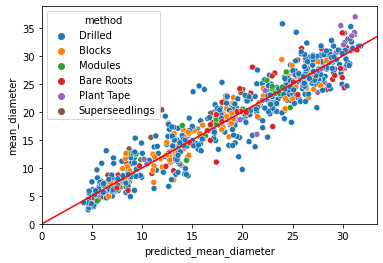

In [21]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', data = test_df, hue='method')
plt.axline([0, 0], [1, 1], color = 'r')
plt.ylim(0)
plt.xlim(0)
plt.show()

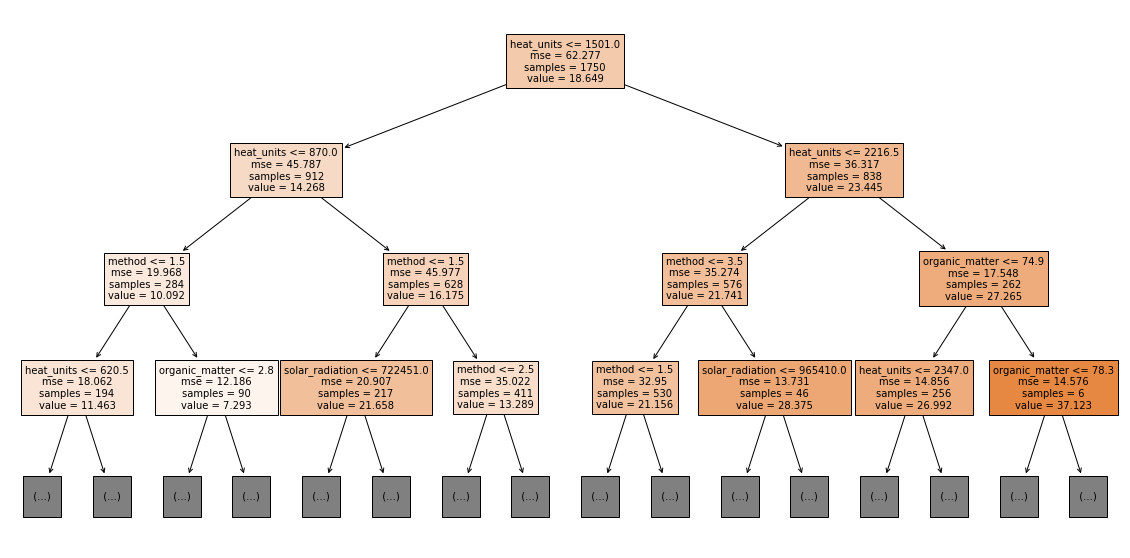

In [22]:
# Tree visualisation to depth of 3.
# Struggling to make visualisation go any deeper.

plt.figure(figsize=(20,10))
tree.plot_tree(rfr[-1].estimators_[0], feature_names=X_train.columns, filled=True, max_depth = 3, fontsize=10)
plt.savefig('Decision Tree.png', dpi=300, bbox_inches = 'tight')
plt.show()

Text(0.5, 0, 'Feature Importance')

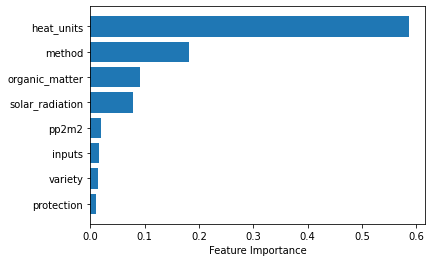

In [23]:
sort = rfr[-1].feature_importances_.argsort()
plt.barh(np.array(X_test.columns)[sort], rfr[-1].feature_importances_[sort])
plt.xlabel("Feature Importance")